# a) MNIST

First, classify hand-written digits on the MNIST dataset, according to the given
training and testing splits on the website. Report the final classification accuracy on the test
set. Additionally, plot the training loss over the iterations.

In [99]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
%matplotlib inline

In [111]:
#Model
class Net(nn.Module):
    def __init__(self,input_size,hidden_size, num_classes):
        super(Net, self).__init__()
        self.input_size = input_size
        self.input   = nn.Linear(input_size,hidden_size, bias=True)
        self.hidden  = nn.Linear(hidden_size,hidden_size, bias=True)
        self.output  = nn.Linear(hidden_size,num_classes, bias=True)
        self.relu    = nn.ReLU()
    def forward(self, x):
        x = x.view(-1,self.input_size)
        x = self.relu(self.input(x))
        x = self.relu(self.hidden(x))
        x = self.relu(self.hidden(x))
        x = self.output(x)
        return F.log_softmax(x, dim=1)

In [116]:
#Training loop
def train(model, device, train_loader, optimizer, epoch):
    
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()

        optimizer.step()
        if batch_idx % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [117]:
#Test Loop
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss

In [101]:
# Build a custom dataset loader to do batchwise tensor&normalize transforms -> faster
from PIL import Image
import codecs

def get_int(b):
    return int(codecs.encode(b, 'hex'), 16)

def read_label_file(path):
    with open(path, 'rb') as f:
        data = f.read()
        assert get_int(data[:4]) == 2049
        length = get_int(data[4:8])
        parsed = np.frombuffer(data, dtype=np.uint8, offset=8)
        return torch.from_numpy(parsed).view(length).long()


def read_image_file(path):
    with open(path, 'rb') as f:
        data = f.read()
        assert get_int(data[:4]) == 2051
        length = get_int(data[4:8])
        num_rows = get_int(data[8:12])
        num_cols = get_int(data[12:16])
        images = []
        parsed = np.frombuffer(data, dtype=np.uint8, offset=16)
        return torch.from_numpy(parsed).view(length, num_rows, num_cols)

class CustomDataset(torch.utils.data.Dataset):
  
    def __init__(self,train=True, transform=None):
        # TODO
        # 1. Initialize file paths or a list of file names.
        self.transform = transform
        self.train = train
        

        if self.train:
            self.data, self.targets =  (read_image_file('train-images.idx3-ubyte'),
                                        read_label_file('train-labels.idx1-ubyte'))
        else:
            self.data, self.targets =  (read_image_file('t10k-images.idx3-ubyte'),
                                        read_label_file('t10k-labels.idx1-ubyte'))
    def __getitem__(self, index):
        # TODO
        # 1. Read one data from file (e.g. using numpy.fromfile, PIL.Image.open).
        # 2. Preprocess the data (e.g. torchvision.Transform).
        # 3. Return a data pair (e.g. image and label).
        img, target = self.data[index], int(self.targets[index])
        img = Image.fromarray(img.numpy(), mode='L')
        # doing this so that it is consistent with all other datasets
        # to return a PIL Image

        if self.transform is not None:
            img = self.transform(img)

        return img, target
    
    def __len__(self):
        return len(self.data) 

In [118]:
# Train&Test Loaders from Torch.DataLoader
train_loader_mnist = torch.utils.data.DataLoader(
        CustomDataset(train=True, 
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
                        batch_size=BS, shuffle=True)
test_loader_mnist = torch.utils.data.DataLoader(
            CustomDataset(train=False,
                          transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=BS, shuffle=True)

(<matplotlib.image.AxesImage at 0x7f0f21f4afd0>, tensor(2))

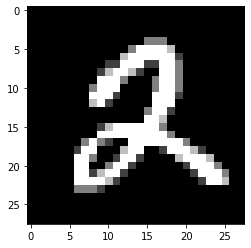

In [119]:
#Check loaded tensors
img, lab = next(iter(train_loader_mnist))
plt.imshow(img[0].numpy().squeeze(),cmap='gray'), lab[0]

In [127]:
#Define hyperparams.
BS     = 128    # Batch Size
epochs = 10
LR     = 0.003  # Learning Rate
CUDA   = True  # True if GPU

In [128]:
#Init model
device = torch.device("cuda" if CUDA else "cpu")
model = Net(input_size=28*28,hidden_size=20,num_classes=10).to(device)
#Optimizer: SGD
optimizer = optim.AdamW(model.parameters(), 
                        lr=LR,
                        weight_decay=1e-2)

In [125]:
model

Net(
  (input): Linear(in_features=784, out_features=20, bias=True)
  (hidden): Linear(in_features=20, out_features=20, bias=True)
  (output): Linear(in_features=20, out_features=10, bias=True)
  (relu): ReLU()
)

In [129]:
#Run Model
loss = []
for epoch in range(1,epochs +1):
    train(model, device, train_loader_mnist, optimizer, epoch)
    l = test(model, device, test_loader_mnist)
    loss.append(l)
torch.save(model.state_dict(), "mnist_mlp.pt")

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.311139
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.504108
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.948230
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.573063
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.608693
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.650403
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.545702
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.517808
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.322418
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.127026
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.156243
Train Epoch: 1 [14080/60000 (23%)]	Loss: 0.644027
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.196659
Train Epoch: 1 [16640/60000 (28%)]	Loss: 0.325341
Train Epoch: 1 [17920/60000 (30%)]	Loss: 0.314305
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.127896
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.213331
Train Epoch: 1 [21760/60000 (36%)]	Loss: 0.289167
Train Epoch: 1 [23040/60000 (38%)]	Loss: 0.371512
Train Epoch: 1 [24320/60000 (41%)]	Loss: 0.271142
Train Epoch: 1 [

Train Epoch: 4 [26880/60000 (45%)]	Loss: 0.092483
Train Epoch: 4 [28160/60000 (47%)]	Loss: 0.157897
Train Epoch: 4 [29440/60000 (49%)]	Loss: 0.092531
Train Epoch: 4 [30720/60000 (51%)]	Loss: 0.223012
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.097202
Train Epoch: 4 [33280/60000 (55%)]	Loss: 0.132260
Train Epoch: 4 [34560/60000 (58%)]	Loss: 0.264831
Train Epoch: 4 [35840/60000 (60%)]	Loss: 0.080331
Train Epoch: 4 [37120/60000 (62%)]	Loss: 0.061515
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.049635
Train Epoch: 4 [39680/60000 (66%)]	Loss: 0.144055
Train Epoch: 4 [40960/60000 (68%)]	Loss: 0.145935
Train Epoch: 4 [42240/60000 (70%)]	Loss: 0.340311
Train Epoch: 4 [43520/60000 (72%)]	Loss: 0.194126
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.114675
Train Epoch: 4 [46080/60000 (77%)]	Loss: 0.223600
Train Epoch: 4 [47360/60000 (79%)]	Loss: 0.090246
Train Epoch: 4 [48640/60000 (81%)]	Loss: 0.284934
Train Epoch: 4 [49920/60000 (83%)]	Loss: 0.336780
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.125172


Train Epoch: 7 [53760/60000 (90%)]	Loss: 0.070399
Train Epoch: 7 [55040/60000 (92%)]	Loss: 0.055227
Train Epoch: 7 [56320/60000 (94%)]	Loss: 0.267465
Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.049972
Train Epoch: 7 [58880/60000 (98%)]	Loss: 0.226402

Test set: Average loss: 0.1666, Accuracy: 9503/10000 (95%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.129430
Train Epoch: 8 [1280/60000 (2%)]	Loss: 0.076612
Train Epoch: 8 [2560/60000 (4%)]	Loss: 0.087908
Train Epoch: 8 [3840/60000 (6%)]	Loss: 0.178125
Train Epoch: 8 [5120/60000 (9%)]	Loss: 0.112102
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.144046
Train Epoch: 8 [7680/60000 (13%)]	Loss: 0.063580
Train Epoch: 8 [8960/60000 (15%)]	Loss: 0.097279
Train Epoch: 8 [10240/60000 (17%)]	Loss: 0.170786
Train Epoch: 8 [11520/60000 (19%)]	Loss: 0.116938
Train Epoch: 8 [12800/60000 (21%)]	Loss: 0.210459
Train Epoch: 8 [14080/60000 (23%)]	Loss: 0.104713
Train Epoch: 8 [15360/60000 (26%)]	Loss: 0.046898
Train Epoch: 8 [16640/60000 (28%)]	Loss: 0.045958
Train

Text(0, 0.5, 'Test Loss')

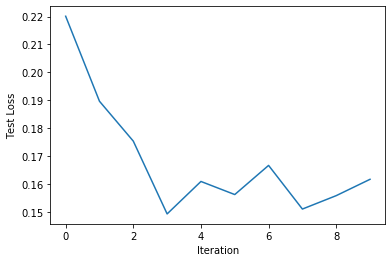

In [131]:
plt.subplot(111)
plt.plot(loss)
plt.xlabel('Iteration')
plt.ylabel('Test Loss')

# b) Faces

For the second part, train a classifier to identify and distinguish between 20 different
people. The dataset is a subset of The ORL Database of Faces and is provided in the file
ORL faces.npz.zip. The size of each image is 92 × 112 pixels, with 256 grey levels per
pixel. It is recommended to visualize the dataset as a sanity check. You can use the provided
load ORL faces.py to load the data. Train your network with the provided training (trainX,
trainY) split and report the classification accuracy for the test (testX, testY) split. Report
the final test accuracy and plot the training loss over the iterations.

In [132]:
# Custom Dataset Loader
from PIL import Image
import numpy as np

class FacesDataset(torch.utils.data.Dataset):
    def __init__(self,train=True, transform=None):
        # TODO
        # 1. Initialize file paths or a list of file names.
        self.transform = transform
        self.train = train
        data = np.load('ORL_faces.npz')
        if self.train:
            self.data, self.targets = data['trainX'], data['trainY']
        else:
            self.data, self.targets = data['testX'], data['testY']
        pass
    def __getitem__(self, index):
        img, target = self.data[index], int(self.targets[index])
        img = img.reshape((112,92))
        img = Image.fromarray(img)
        if self.transform is not None:
            img = self.transform(img)

        return img, target
    
    def __len__(self):
        return len(self.data) 

In [144]:
#Define hyperparams.
BS     = 20   # Batch Size
epochs = 100
LR     = 0.003  # Learning Rate
CUDA   = True  # True if GPU

In [134]:
#Calculate our dataset mean to normalize
def get_mean_and_std(dataset):
    '''Compute the mean and std value of dataset.'''
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)
    mean = torch.zeros(1)
    std = torch.zeros(1)
    print('==> Computing mean and std..')
    for inputs, targets in dataloader:
        inputs
        for i in range(1):
            mean[i] += inputs[:,i,:,:].mean()
            std[i] += inputs[:,i,:,:].std()
    mean.div_(len(dataset))
    std.div_(len(dataset))
    return mean, std
get_mean_and_std(FacesDataset(train=False, 
                       transform=transforms.Compose([
                           transforms.ToTensor()
                       ])))

==> Computing mean and std..


(tensor([118.7025]), tensor([50.8585]))

In [86]:
#Dataset normalize
# train (tensor([117.7359]), tensor([49.7357]))
# test  (tensor([118.7026]), tensor([50.8585]))

In [135]:

train_loader_face = torch.utils.data.DataLoader(
            FacesDataset(train=True, 
               transform=transforms.Compose([
                   transforms.ToTensor(),
                   transforms.Normalize((117.7359,), (49.7357,))
               ])),
                batch_size=BS, shuffle=True)
test_loader_face = torch.utils.data.DataLoader(
            FacesDataset(train=False,
                  transform=transforms.Compose([
                   transforms.ToTensor(),
                   transforms.Normalize((118.7026,), (50.8585,))
               ])),
                batch_size=BS, shuffle=True)

(<matplotlib.image.AxesImage at 0x7f0f21906190>, tensor(5))

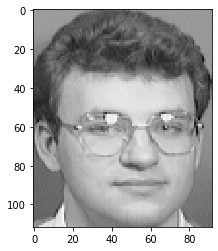

In [136]:
#check our tensors
img, lab = next(iter(test_loader_face))
plt.imshow(img[0].numpy().squeeze(),cmap='gray'), lab[0]

In [145]:
#Init model
device = torch.device("cuda:0" if CUDA else "cpu")
model_faces = Net(input_size=92*112,hidden_size=20, num_classes=20).to(device)
#Optimizer: SGD
optimizer = optim.AdamW(model_faces.parameters(), 
                        lr=LR,
                        weight_decay=1e-2)

In [146]:
model_faces

Net(
  (input): Linear(in_features=10304, out_features=20, bias=True)
  (hidden): Linear(in_features=20, out_features=20, bias=True)
  (output): Linear(in_features=20, out_features=20, bias=True)
  (relu): ReLU()
)

In [147]:
#Run Model
loss = []
for epoch in range(1,epochs +1):
    train(model_faces, device, train_loader_face, optimizer, epoch)
    l = test(model_faces, device, test_loader_face)
    loss.append(l)
torch.save(model_faces.state_dict(), "faces_mlp.pt")

Train Epoch: 1 [0/240 (0%)]	Loss: 3.019943

Test set: Average loss: 2.5082, Accuracy: 36/160 (22%)

Train Epoch: 2 [0/240 (0%)]	Loss: 2.170003

Test set: Average loss: 1.8215, Accuracy: 63/160 (39%)

Train Epoch: 3 [0/240 (0%)]	Loss: 1.982972

Test set: Average loss: 1.4751, Accuracy: 86/160 (54%)

Train Epoch: 4 [0/240 (0%)]	Loss: 0.673349

Test set: Average loss: 1.1742, Accuracy: 101/160 (63%)

Train Epoch: 5 [0/240 (0%)]	Loss: 0.454778

Test set: Average loss: 0.9462, Accuracy: 111/160 (69%)

Train Epoch: 6 [0/240 (0%)]	Loss: 0.331555

Test set: Average loss: 0.7418, Accuracy: 116/160 (72%)

Train Epoch: 7 [0/240 (0%)]	Loss: 0.076917

Test set: Average loss: 0.5962, Accuracy: 133/160 (83%)

Train Epoch: 8 [0/240 (0%)]	Loss: 0.049300

Test set: Average loss: 0.7230, Accuracy: 134/160 (84%)

Train Epoch: 9 [0/240 (0%)]	Loss: 0.080977

Test set: Average loss: 0.6377, Accuracy: 140/160 (88%)

Train Epoch: 10 [0/240 (0%)]	Loss: 0.014226

Test set: Average loss: 0.5909, Accuracy: 139/160


Test set: Average loss: 0.6180, Accuracy: 146/160 (91%)

Train Epoch: 83 [0/240 (0%)]	Loss: 0.000134

Test set: Average loss: 0.6195, Accuracy: 146/160 (91%)

Train Epoch: 84 [0/240 (0%)]	Loss: 0.000198

Test set: Average loss: 0.6188, Accuracy: 146/160 (91%)

Train Epoch: 85 [0/240 (0%)]	Loss: 0.000181

Test set: Average loss: 0.6186, Accuracy: 146/160 (91%)

Train Epoch: 86 [0/240 (0%)]	Loss: 0.000168

Test set: Average loss: 0.6202, Accuracy: 146/160 (91%)

Train Epoch: 87 [0/240 (0%)]	Loss: 0.000210

Test set: Average loss: 0.6216, Accuracy: 146/160 (91%)

Train Epoch: 88 [0/240 (0%)]	Loss: 0.000171

Test set: Average loss: 0.6219, Accuracy: 146/160 (91%)

Train Epoch: 89 [0/240 (0%)]	Loss: 0.000170

Test set: Average loss: 0.6216, Accuracy: 146/160 (91%)

Train Epoch: 90 [0/240 (0%)]	Loss: 0.000138

Test set: Average loss: 0.6215, Accuracy: 147/160 (92%)

Train Epoch: 91 [0/240 (0%)]	Loss: 0.000163

Test set: Average loss: 0.6224, Accuracy: 147/160 (92%)

Train Epoch: 92 [0/240 (

Text(0, 0.5, 'Test Loss')

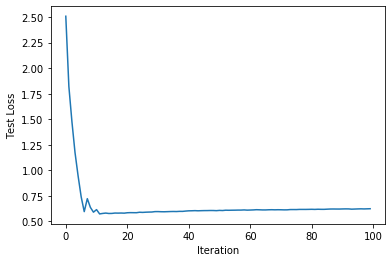

In [148]:
plt.subplot(111)
plt.plot(loss)
plt.xlabel('Iteration')
plt.ylabel('Test Loss')